In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../../')
from noise2seg.models import Noise2Seg, Noise2SegConfig
import numpy as np
from csbdeep.utils import plot_history
from noise2seg.utils.misc_utils import combine_train_test_data, shuffle_train_data, augment_data
from noise2seg.utils.seg_utils import *
from noise2seg.utils.compute_precision_threshold import measure_precision
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from scipy import ndimage
import tensorflow as tf
import keras.backend as K
import urllib
import os
import zipfile

Using TensorFlow backend.


In [2]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

# check if data has been downloaded already
zipPath="data/DSB.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://owncloud.mpi-cbg.de/index.php/s/LIN4L4R9b2gebDX/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [3]:
trainval_data =  np.load('data/DSB/train_data/dsb2018_TrainVal40.npz')
test_data =  np.load('data/DSB/test_data/dsb2018_Test40.npz', allow_pickle=True)
train_images = trainval_data['X_train'].astype(np.float32)
val_images = trainval_data['X_val'].astype(np.float32)
test_images = test_data['X_test']

train_masks = trainval_data['Y_train']
val_masks = trainval_data['Y_val']
test_masks = test_data['Y_test']

In [4]:
print("Shape of train_images: ", train_images.shape, ", Shape of train_masks: ", train_masks.shape)
print("Shape of val_images: ", val_images.shape, ", Shape of val_masks: ", val_masks.shape)
print("Shape of test_images: ", test_images.shape, ", Shape of test_masks: ", test_masks.shape)

Shape of train_images:  (3800, 128, 128) , Shape of train_masks:  (3800, 128, 128)
Shape of val_images:  (670, 128, 128) , Shape of val_masks:  (670, 128, 128)
Shape of test_images:  (50,) , Shape of test_masks:  (50,)


In [5]:
fraction = 0.25 # Fraction of annotated GT and raw image pairs to use during training. 
random_seed = 1 # Seed to shuffle training data (annotated GT and raw image pairs).


assert 0 <fraction<= 100, "Fraction should be between 0 and 100"

X_shuffled, Y_shuffled = shuffle_train_data(train_images, train_masks, random_seed = random_seed)
X_frac, Y_frac = zero_out_train_data(X_shuffled, Y_shuffled, fraction = fraction)
print("Training Data \n..................")
X, Y_train_masks = augment_data(X_frac, Y_frac)
print("\n")
print("Validation Data \n..................")
X_val, Y_val_masks = val_images, val_masks

Training Data 
..................
Raw image size after augmentation (30400, 128, 128)
Mask size after augmentation (30400, 128, 128)


Validation Data 
..................


In [6]:
X = X[...,np.newaxis]
Y = convert_to_oneHot(Y_train_masks)
X_val = X_val[...,np.newaxis]
Y_val = convert_to_oneHot(Y_val_masks)
print("Shape of train images: ", X.shape, ", Shape of train masks: ", Y.shape)
print("Shape of validation images: ", X_val.shape, ", Shape of validation masks: ", Y_val.shape)

Shape of train images:  (30400, 128, 128, 1) , Shape of train masks:  (30400, 128, 128, 3)
Shape of validation images:  (670, 128, 128, 1) , Shape of validation masks:  (670, 128, 128, 3)


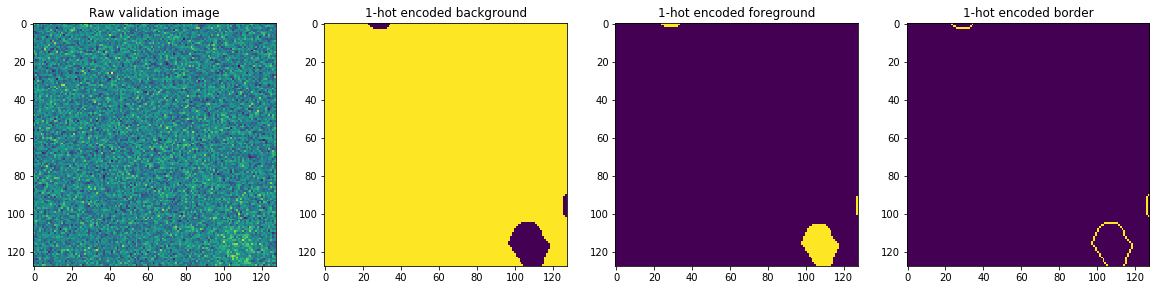

In [7]:
sl = 1
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X[sl,...,0])
plt.title('Raw validation image')
plt.subplot(1,4,2)
plt.imshow(Y[sl,...,0], vmin=0, vmax=1)
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y[sl,...,1], vmin=0, vmax=1)
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y[sl,...,2], vmin=0, vmax=1)
plt.title('1-hot encoded border');

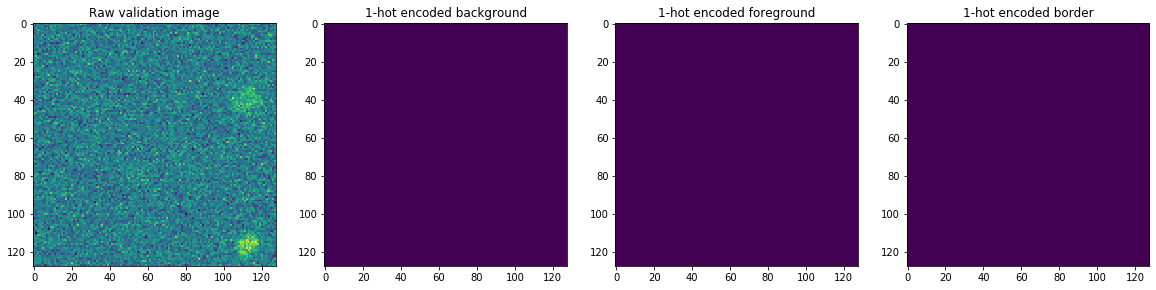

In [8]:
sl = -1
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X[sl,...,0])
plt.title('Raw validation image')
plt.subplot(1,4,2)
plt.imshow(Y[sl,...,0], vmin=0, vmax=1)
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y[sl,...,1], vmin=0, vmax=1)
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y[sl,...,2], vmin=0, vmax=1)
plt.title('1-hot encoded border');

In [9]:
train_batch_size = 128
train_steps_per_epoch = int(X.shape[0]/train_batch_size)

In [10]:
n2s_conf = Noise2SegConfig(X, unet_kern_size=3, n_channel_out=4, relative_weights = [1.0,1.0,5.0],
                   train_steps_per_epoch=train_steps_per_epoch, train_epochs=20, train_loss='noise2seg', batch_norm=True, 
                   train_batch_size=train_batch_size, unet_n_first = 32, unet_n_depth=4, 
                   n2s_alpha=0.5,
                          train_tensorboard=False)

vars(n2s_conf)

{'means': ['13.486088'],
 'stds': ['44.00652'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 4,
 'train_loss': 'noise2seg',
 'unet_n_depth': 4,
 'relative_weights': [1.0, 1.0, 5.0],
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'probabilistic': False,
 'unet_residual': False,
 'unet_input_shape': (None, None, 1),
 'train_epochs': 20,
 'train_steps_per_epoch': 237,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': False,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 1.5,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'n2s_alpha': 0.5}

# <div style='color:red'>Tensorboard is not working!</div>

In [11]:
model_name = 'n2s_monitor_seg_alpha0.5'
basedir = 'models'
n2s_model = Noise2Seg(n2s_conf, model_name, basedir)

In [12]:
history = n2s_model.train(X, Y, (X_val, Y_val))

Preparing validation data:   2%|▏         | 16/670 [00:00<00:04, 151.33it/s]

61 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 670/670 [00:04<00:00, 144.41it/s]




Epoch 1/20
237/237 [==============================] - 72s 306ms/step - loss: 0.4340 - noise2seg: 0.4340 - seg_loss: 0.0018 - denoise_loss: 0.4322 - val_loss: 0.9281 - val_noise2seg: 0.9281 - val_seg_loss: 0.5085 - val_denoise_loss: 0.4196
Epoch 2/20
237/237 [==============================] - 64s 272ms/step - loss: 0.4216 - noise2seg: 0.4216 - seg_loss: 0.0013 - denoise_loss: 0.4203 - val_loss: 0.8592 - val_noise2seg: 0.8592 - val_seg_loss: 0.4412 - val_denoise_loss: 0.4179
Epoch 3/20
237/237 [==============================] - 66s 278ms/step - loss: 0.4197 - noise2seg: 0.4197 - seg_loss: 9.3531e-04 - denoise_loss: 0.4188 - val_loss: 0.7840 - val_noise2seg: 0.7840 - val_seg_loss: 0.3672 - val_denoise_loss: 0.4168
Epoch 4/20
237/237 [==============================] - 64s 272ms/step - loss: 0.4192 - noise2seg: 0.4192 - seg_loss: 7.3231e-04 - denoise_loss: 0.4184 - val_loss: 0.7461 - val_noise2seg: 0.7461 - val_seg_loss: 0.3270 - val_denoise_loss: 0.4192
Epoch 5/20
237/237 [==============

In [13]:
history.history.keys()

dict_keys(['val_loss', 'val_noise2seg', 'val_seg_loss', 'val_denoise_loss', 'loss', 'noise2seg', 'seg_loss', 'denoise_loss', 'lr'])

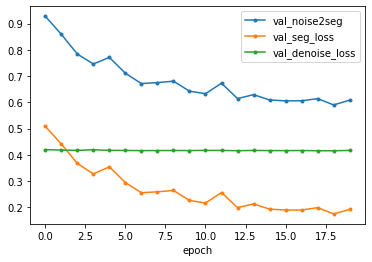

In [14]:
plot_history(history, ['val_noise2seg', 'val_seg_loss', 'val_denoise_loss'])

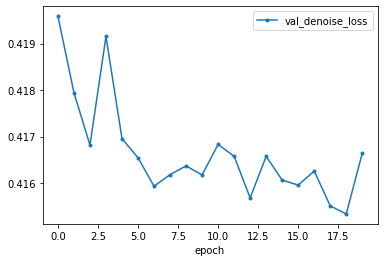

In [15]:
plot_history(history, ['val_denoise_loss'])

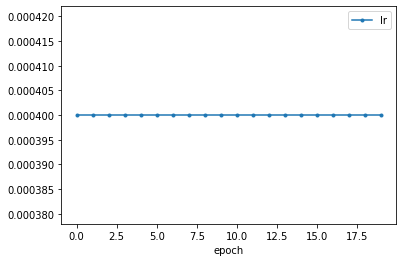

In [16]:
plot_history(history, ['lr'])

In [24]:
threshold, val_score = n2s_model.optimize_thresholds(val_images.astype(np.float32), val_masks, measure=measure_precision())
print(threshold, val_score)

Computing best threshold: 


Score for threshold = 0.10 is 0.4687
Score for threshold = 0.15 is 0.5381
Score for threshold = 0.20 is 0.5618
Score for threshold = 0.25 is 0.5783
Score for threshold = 0.30 is 0.5751
Score for threshold = 0.35 is 0.5676
Score for threshold = 0.40 is 0.5488
Score for threshold = 0.45 is 0.5308
Score for threshold = 0.50 is 0.4995
Score for threshold = 0.55 is 0.4508
Score for threshold = 0.60 is 0.3877
Score for threshold = 0.65 is 0.2884
Score for threshold = 0.70 is 0.1812
Score for threshold = 0.75 is 0.0959
Score for threshold = 0.80 is 0.0369
Score for threshold = 0.85 is 0.0117
Score for threshold = 0.90 is 0.0031
Score for threshold = 0.95 is 0.0001
Score for threshold = 1.00 is 0.0000

0.25 0.5782609451004732


In [25]:
predicted_images, precision_result = n2s_model.predict_label_masks(test_images, test_masks, threshold, 
                                                                   measure=measure_precision())
print("Average precision over all test images at IOU = 0.5, threhold = {}: ".format(round(threshold, 3)), 
      precision_result)

Average precision over all test images at IOU = 0.5, threhold = 0.25:  0.44590763806109224
